# Installation
CNGI documentation is located here:
[https://cngi-prototype.readthedocs.io/en/latest/index.html](https://cngi-prototype.readthedocs.io/en/latest/index.html)

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide

In [1]:
import os
import numpy as np
import logging
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR) # dask is noisy

print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks==6.0.0.27")
os.system("pip install cngi-prototype==0.0.23")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


# Initialize the Processing Environment
InitializeFramework instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well.  The code is shown here commented out for reference only.

In [0]:
# normally you would want to run something like this on a local machine
#from cngi.direct import InitializeFramework
#client = InitializeFramework(workers=2, memory='6GB')
#print(client)

# Create a CASA Image
First we need to create a CASA image by calling CASA6 tclean on the CASAguide MS

Pro tip: you can see the files being created by expanding the left navigation bar in colab (little arrow on top left) and going to "Files"

In [3]:
from casatasks import tclean
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='sis14_twhya_calibrated_flagged', field='5', spw='',
       specmode='cube', deconvolver='hogbom', nterms=1, imsize=[250,250], gridder='standard', cell=['0.1arcsec'],
       nchan=10, weighting='natural', threshold='0mJy', niter=5000, interactive=False, savemodel='modelcolumn',
       usemask='auto-multithresh')
print('complete')

complete


# Convert the Image products to xarray/zarr format
tclean produces an image along with a number of supporting products (residual, pb, psf, etc) in their own separate directories.  

CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) data model and the zarr storage format which is capable of storing all image products (of the same shape) together.

Note that the .mask image product will be renamed to 'deconvolve' in the xarray data model and 'mask' will hold the mask pixel values extracted from the .image.

In [4]:
import dask
from cngi.conversion import image_to_zarr

image_to_zarr('sis14_twhya_calibrated_flagged.image')

converting Image...
compatible components:  ['image', 'mask', 'model', 'pb', 'psf', 'residual', 'sumwt']
separate components:  []


/usr/local/lib/python3.6/dist-packages/xarray/backends/api.py:1240: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  and not np.issubdtype(var.dtype, np.bool)


processed image size [250 250   1  10] in 1.3841124 seconds


# Open a zarr format Image

Open the zarr format image and print its contents.  Note that the zarr file has all the image products in it (rather than separate directories)


In [0]:
from cngi.dio import read_image

# returns an xarray dataset representation of the specified zarr directory
image_xds = read_image('sis14_twhya_calibrated_flagged.img.zarr')

Within the xarray dataset image, we can see a very clear definition of the image properties.  The **Dimensions** section holds the size of the image, while the **Coordinates** section defines the values of each dimension.  The actual image (and supporting products) are stored in the **Data variables** section.  Lastly, the **Attributes** section holds the remaining metadata.

Note that the variables *image*, *deconvolve*, *mask*, *model*, *pb*, *psf*, and *residual* all share the same dimensions of 250x250x1x10 while the variable *sumwt* is a subset of dimensions 1x10

In [6]:
print(image_xds)

<xarray.Dataset>
Dimensions:          (d0: 250, d1: 250, frequency: 10, pol: 1)
Coordinates:
    declination      (d0, d1) float64 dask.array<chunksize=(125, 250), meta=np.ndarray>
  * frequency        (frequency) float64 3.725e+11 3.725e+11 ... 3.725e+11
    right_ascension  (d0, d1) float64 dask.array<chunksize=(125, 250), meta=np.ndarray>
  * pol              (pol) float64 1.0
Dimensions without coordinates: d0, d1
Data variables:
    deconvolve       (d0, d1, pol, frequency) bool dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    image            (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    mask             (d0, d1, pol, frequency) bool dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    model            (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    pb               (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    psf           

The image has both cartesian pixel coordinates (d0, d1) and spherical world coordinates (right_ascension, declination).

# Preview Image
We can quickly spot check image contents.  This is also handy later on during image manipulation and analysis.

The image is plotted using its spherical world coordinates, although many operations may be on cartesian pixel coordinates.

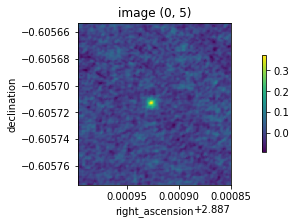

In [7]:
from cngi.image import preview
preview(image_xds, 'image', channels=5)

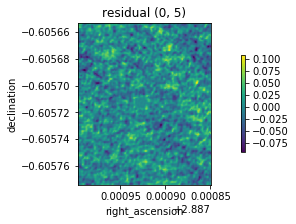

In [8]:
preview(image_xds, 'residual', channels=5)

# Image Manipulation
Many image operations can be easily done directly on the image xarray dataset

**Example 1: imsubimage** - copy all or part of an image to a new image

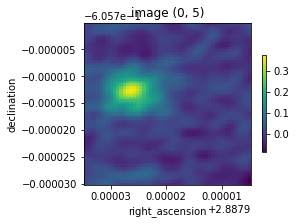

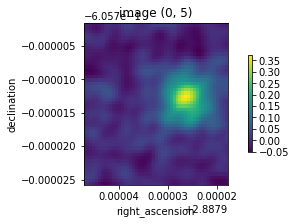

In [9]:
# selection by coordinate values
image_xds2 = image_xds.where( (image_xds.right_ascension > 2.887905) & (image_xds.right_ascension < 2.887935) &
                              (image_xds.declination > -0.60573) & (image_xds.declination < -0.60570), drop=True ) 
preview(image_xds2, channels=5)

# selection by pixel indices (50x50 pixel square)
# note that this same method works for any other dimension (pol, channels, etc)
image_xds2 = image_xds.isel(d0=np.arange(50)+85, d1=np.arange(50)+100) 
preview(image_xds2, channels=5)

**Example 2: imtrans** - reorders (transposes) the axes in the input image to the specified order

This can be done on the entire dataset, or just one variable in the dataset. Here we will do it on the whole thing which is probably best if you want to preserve your regions and masks (explained later).  This will generally not affect the preview plot since it selects axes by name rather than index. That is one advantage of xarray over numpy.

In [10]:
image_xds2 = image_xds.transpose('frequency','d1','d0','pol')
print('Before\n', image_xds.data_vars)
print('\nAfter\n', image_xds2.data_vars)

Before
 Data variables:
    deconvolve  (d0, d1, pol, frequency) bool dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    image       (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    mask        (d0, d1, pol, frequency) bool dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    model       (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    pb          (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    psf         (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    residual    (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    sumwt       (pol, frequency) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

After
 Data variables:
    deconvolve  (frequency, d1, d0, pol) bool dask.array<chunksize=(1, 250, 250, 1), meta=np.ndarray>
    image       (frequency, d1, d0

**Example 3: imcollapse** - collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

Again, this can be done on the entire dataset, or just one variable in the dataset. Refer to the [xarray documentation](http://xarray.pydata.org/en/stable/api.html#dataset) for supported aggregation functions, or write your own and call *reduce*.  This will generally break the preview plot since it is expecting a 4-D cube with ra, dec, pol, and frequency axes

In [11]:
# one dimension collapse
image_xds2 = image_xds.sum(dim='frequency')
print('One dimension collapse\n', image_xds2.data_vars)

# multi-dimension collapse
image_xds2 = image_xds.mean(dim=['d0','d1'])
print('\nMulti-dimension collapse\n', image_xds2.data_vars)


One dimension collapse
 Data variables:
    deconvolve  (d0, d1, pol) int64 dask.array<chunksize=(250, 250, 1), meta=np.ndarray>
    image       (d0, d1, pol) float64 dask.array<chunksize=(125, 250, 1), meta=np.ndarray>
    mask        (d0, d1, pol) int64 dask.array<chunksize=(250, 250, 1), meta=np.ndarray>
    model       (d0, d1, pol) float64 dask.array<chunksize=(125, 250, 1), meta=np.ndarray>
    pb          (d0, d1, pol) float64 dask.array<chunksize=(125, 250, 1), meta=np.ndarray>
    psf         (d0, d1, pol) float64 dask.array<chunksize=(125, 250, 1), meta=np.ndarray>
    residual    (d0, d1, pol) float64 dask.array<chunksize=(125, 250, 1), meta=np.ndarray>
    sumwt       (pol) float64 dask.array<chunksize=(1,), meta=np.ndarray>

Multi-dimension collapse
 Data variables:
    deconvolve  (pol, frequency) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    image       (pol, frequency) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    mask        (pol, frequency) flo

# Regions and Masks
Both regions and masks are stored as boolean arrays in the same xarray dataset alongside the rest of the image components.  They always share the same dimensions as the image.

They are both now treated as the same thing, so a value of 0 means "discard this pixel" and a value of 1 means "keep this pixel" regardless of whether it is a mask or a region.  In fact, any xarray data variable of boolean type can be used as a region/mask, there is nothing special about the names.

Regions/masks can be set across any dimension, so they can be per-channel and per-polarization as well as the spatial dimensions.

First lets create a couple examples:

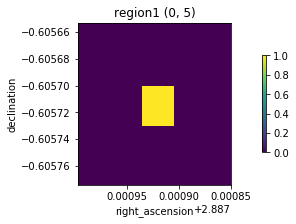

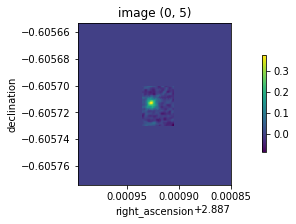

In [12]:
from cngi.image import region

# region 1 is an ra/dec box across all channels
image_xds2 = region(image_xds, 'region1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

# lets examine what it looks like
preview(image_xds2,'region1', channels=5)

# and combined with our image
preview(image_xds2, 'image', 'region1', channels=5)

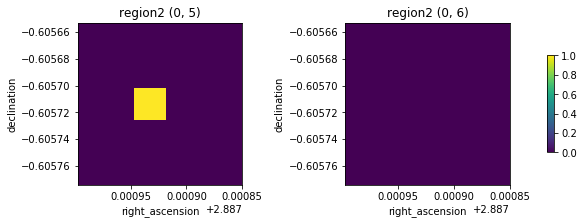

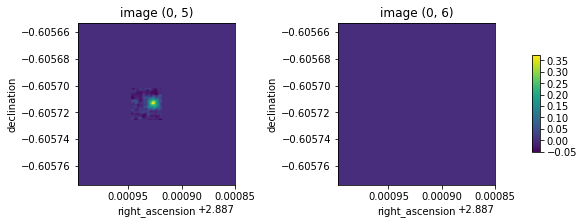

In [13]:
# region 2 is a pixel box across channels 3, 4 and 5
image_xds3 = region(image_xds2, 'region2', pixels=[[85,100],[135,150]], channels=[3,4,5])

# observe the change in behavior across channels
preview(image_xds3,'region2', channels=[5,6])
preview(image_xds3, 'image', 'region2', channels=[5,6])

Regions are just data variables in the xarray dataset. So we can manipulate them the same way we can any other variable.

In [14]:
image_xds3.data_vars

Data variables:
    deconvolve  (d0, d1, pol, frequency) bool dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    image       (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    mask        (d0, d1, pol, frequency) bool dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    model       (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    pb          (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    psf         (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    residual    (d0, d1, pol, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    sumwt       (pol, frequency) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    region1     (d0, d1, pol, frequency) bool dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    region2     (d0, d1, pol, frequency) bool dask.array<chunksize

Let's combine the first two regions in to a new one (doesn't need to be contiguous, although it is here). It is just a logical OR of two boolean arrays (obviously you could do an AND, XOR, or whatever else).

Just keep in mind that these are 4-D arrays, not 2-D.

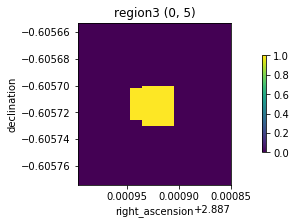

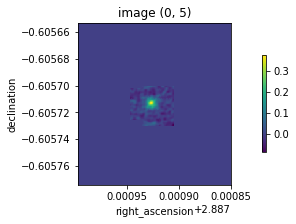

In [15]:
region3 = image_xds3.region1 | image_xds3.region2
image_xds4 = image_xds3.assign(dict([('region3', region3)]))
 
preview(image_xds4,'region3', channels=5)
preview(image_xds4, 'image', 'region3', channels=5)

Masks are just like regions but with inverse logic used to set them.  Here is the same code again using calls to mask instead of region.

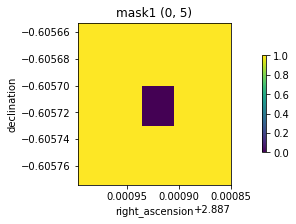

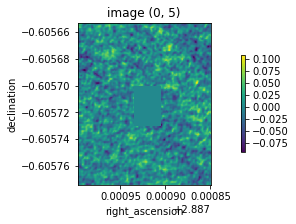

In [16]:
from cngi.image import mask

image_xds2 = mask(image_xds, 'mask1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

preview(image_xds2,'mask1', channels=5)
preview(image_xds2, 'image', 'mask1', channels=5)

Our converted image actually had two masks in it already, the variables *mask* and *deconvolve*.  Deconvolve is named differently because it is the mask set by auto-masking for the deconvolution rather than an image mask.  

These actually look a lot more like regions than masks, but that's the terminology that was used.  Again, they are the same thing anyway

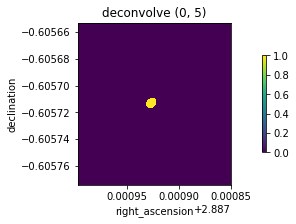

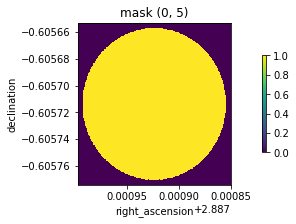

In [17]:
preview(image_xds2, 'deconvolve', channels=5)
preview(image_xds2, 'mask', channels=5)

# Manipulation with Regions and Masks

All of the previously discussed image manipulation techniques can be done with regions and masks applied.  Just subselect the pixels within the region (outside the mask) first.  This is done with *dataset.where(..., drop=True)* 

Here is example 3 again with a region applied.

**Example 3: imcollapse** - collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

Mean pixel values by channel :  [0.         0.0009337  0.00062645 0.00089679 0.00076623 0.00075292
 0.00072544 0.00098671 0.00082494 0.00076202] 



/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1272: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


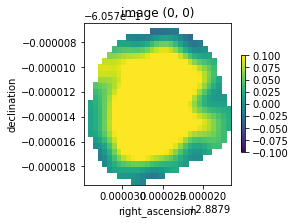


With deconvolve mask applied :  [0.10398341 0.09321037 0.11130808 0.18811812 0.18880713 0.11977938
 0.12009657 0.09283661 0.10214104]


In [18]:
# full image collapse
image_xds2 = image_xds.mean(dim=['d0','d1'])
print('Mean pixel values by channel : ', image_xds2.isel(pol=0).image.values, '\n')

# apply deconvolve region from auto-masking
image_xds2 = image_xds.where(image_xds.deconvolve, drop=True)
preview(image_xds2)

# collapse just the region
image_xds2 = image_xds2.mean(dim=['d0','d1'])
print('\nWith deconvolve mask applied : ', image_xds2.isel(pol=0).image.values)